# Contrail detection: Objective-2 Baseline Tuning

## Data Collection & Exploration

- Pytorch dataset 
- Normalization 
- Ash RGB selection
- Gaussian Filter data selection
- U-Net Tuned Model
- Backbone based U-Net

In [1]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module
import config
import src.utils as utils
from src.dataset import ContrailsDataset
from src.model import BaseUnet, SegmentLightning, AttentionUNet
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

## Tensorboard Modules
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Memory management
def clear_torch_cache():
    torch.cuda.empty_cache()
    print("Cleared PyTorch GPU cache.")

# Run the function to clear GPU cache
clear_torch_cache()

!nvidia-smi

Cleared PyTorch GPU cache.
Thu Aug 15 19:45:22 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:04:00.0 Off |                  Off |
| 41%   44C    P8     8W / 140W |   7366MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

## Datasets

In [2]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
df = pd.read_csv(config.CSV_TRAIN_REC, index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.head()

,Image_ID,Class
16081,8975896718947475053,0
17494,2887461863286016746,0
15040,1323985642378913441,1
7528,8578962451401293377,0
18488,1733973341297589475,1


In [3]:
## Training Sample
train_df = train_df.head(5000)
valid_df = valid_df.head(1000)

In [4]:
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x/299.0),
    #transforms.Lambda(lambda x: utils.get_rgb(x)),
    #transforms.Lambda(lambda x: utils.gaussian_filter_normalization(x)),
    #transforms.Lambda(lambda x: utils.contrail_detection_preprocessing(x))
                      ])


train_dataset = ContrailsDataset(dataframe=train_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                 sequence_index=config.TS # nth:5 sequence image
                                )

## Data Loaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              prefetch_factor=config.WORKERS,
                             )

## Validation Dataloader 
valid_dataset = ContrailsDataset(dataframe=valid_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                 sequence_index=config.TS
                                )

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE,
                              shuffle=False,
                              num_workers=config.WORKERS,
                              prefetch_factor=config.WORKERS
                             )

In [5]:
image, mask = next(iter(train_dataloader))
image.shape, mask.shape

(torch.Size([8, 9, 256, 256]), torch.Size([8, 1, 256, 256]))

### Bands Visualization

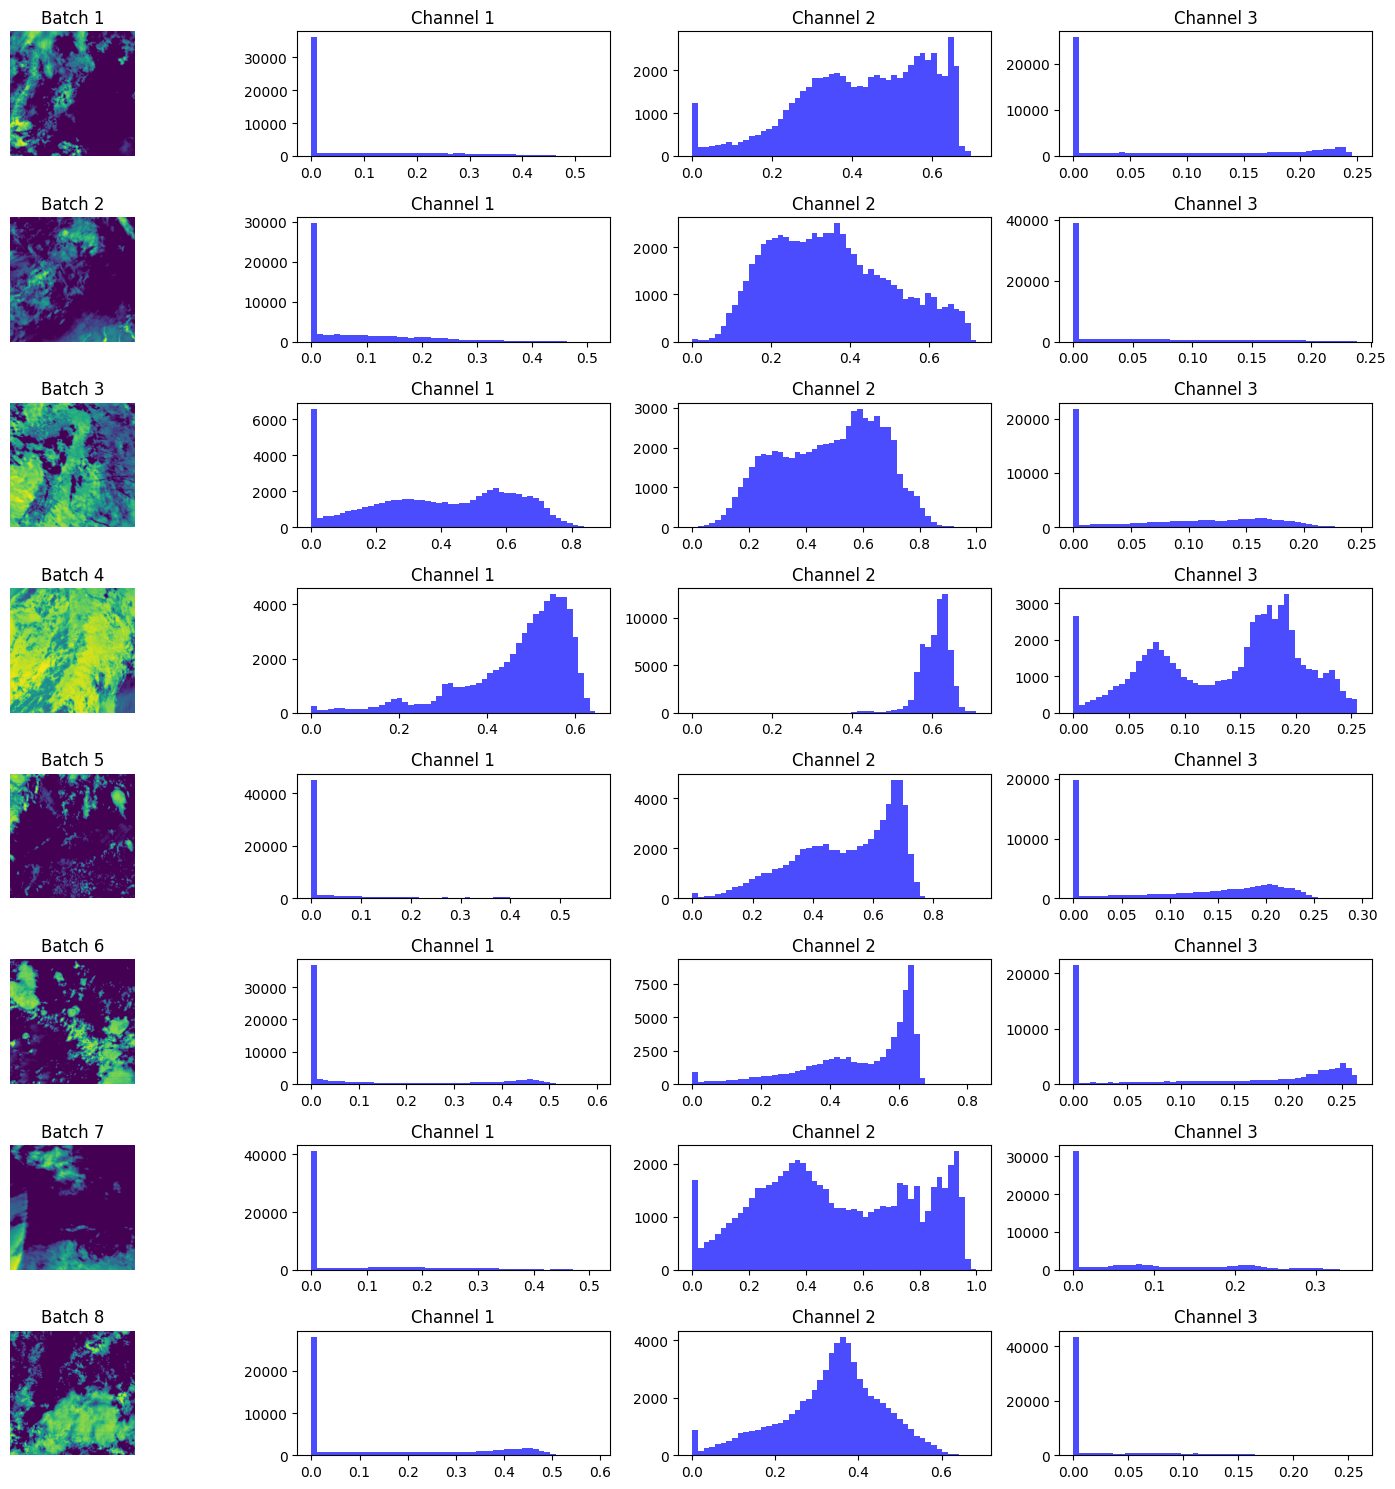

In [7]:
utils.plot_batch_histogram(image)

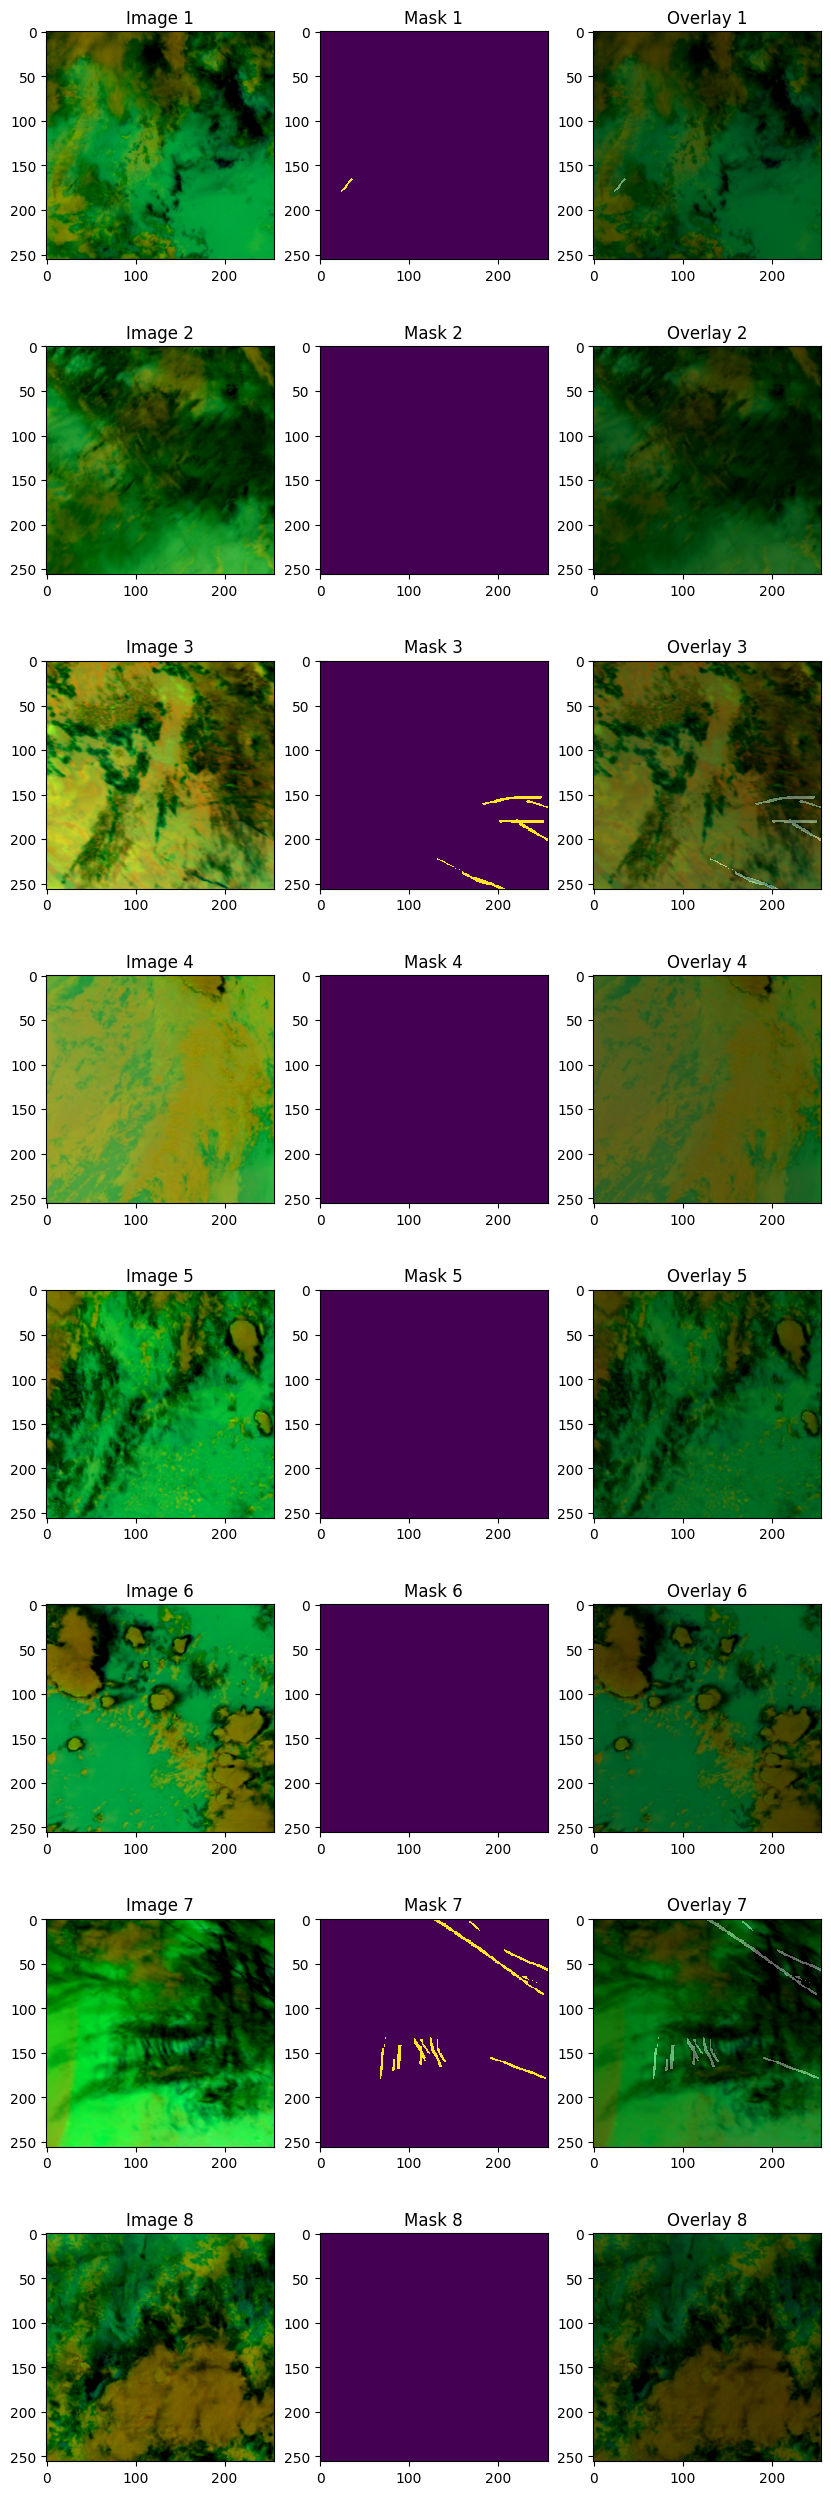

In [8]:
utils.plot_image_and_mask(image, mask)

## Models 

### Baseline U-Net Model Experiments

In [9]:
## Loss function
class TverskyLoss(torch.nn.Module):
    def __init__(self, alpha=0.3, beta=0.7):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, inputs, targets):
        smooth = 1.0
        inputs = torch.sigmoid(inputs)
        true_pos = torch.sum(targets * inputs)
        false_neg = torch.sum(targets * (1 - inputs))
        false_pos = torch.sum((1 - targets) * inputs)
        return 1 - (true_pos + smooth) / (true_pos + self.alpha * false_neg + self.beta * false_pos + smooth)

In [ ]:
# Define all combinations of features and loss functions
features_list = [[32, 64, 128, 256], [64, 128, 256, 512]]
loss_functions = ['BCEWithLogitsLoss', 'TverskyLoss']

# Iterate over each combination of features and loss functions
for features in features_list:
    for loss_function in loss_functions:
        params = {
            'learning_rate': 1e-4,
            'batch_size': 8,
            'dropout_prob': 0.0,
            'features': features,
            'optimizer': 'Adam',
            'scheduler': 'ReduceLROnPlateau',
            'loss_function': loss_function
        }

        model = BaseUnet(
            in_channels=3,
            out_channels=1,
            features=params['features']
        )

        if params['loss_function'] == 'BCEWithLogitsLoss':
            criterion = torch.nn.BCEWithLogitsLoss()
        elif params['loss_function'] == 'TverskyLoss':
            criterion = TverskyLoss(alpha=0.7, beta=0.3)
            
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        # Pytorch lighting training
        lightning_model = SegmentLightning(
            model=model,
            criterion=criterion,
            learning_rate=params['learning_rate'],
            scheduler_name=params['scheduler'],
            scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6},
            train_dataset=train_dataset,
            val_dataset=valid_dataset,
            batch_size=params['batch_size']
        )

        # Customize the logger name based on parameters
        log_name = f"UNet_GaussBands_{params['features'][0]}_{params['features'][-1]}_{params['loss_function']}"
        logger = TensorBoardLogger('tb_logs_obj2', name=log_name)

        checkpoint_callback = ModelCheckpoint(
            dirpath=f'./model_checkpoints/obj2/{logger.name}',
            monitor='val_loss',
            save_top_k=3,
            save_last=True
        )
        early_stop_callback = EarlyStopping(monitor='val_loss', patience=5)

        trainer = pl.Trainer(
            max_epochs=30,
            logger=logger,
            precision=config.PRECISION,
            accelerator=config.ACCELERATOR,
            devices=[0],
            min_epochs=1,
            callbacks=[checkpoint_callback, early_stop_callback],
        )

        # Start the training process
        trainer.fit(lightning_model)

        print(f"Completed Training: Features {params['features']} with {params['loss_function']} Loss")

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs_obj2/UNet_GaussBands_32_256_BCEWithLogitsLoss
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type              | Params
-------------------------------------------------------
0 | model            | BaseUnet          | 7.8 M 
1 | criterion        | BCEWithLogitsLoss | 0     
2 | iou              | JaccardIndex      | 0     
3 | dice_coefficient | Dice              | 0     
-------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
15.534    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Completed Training: Features [32, 64, 128, 256] with BCEWithLogitsLoss Loss


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs_obj2/UNet_GaussBands_32_256_TverskyLoss
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type         | Params
--------------------------------------------------
0 | model            | BaseUnet     | 7.8 M 
1 | criterion        | TverskyLoss  | 0     
2 | iou              | JaccardIndex | 0     
3 | dice_coefficient | Dice         | 0     
--------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
15.534    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Completed Training: Features [32, 64, 128, 256] with TverskyLoss Loss


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs_obj2/UNet_GaussBands_64_512_BCEWithLogitsLoss
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type              | Params
-------------------------------------------------------
0 | model            | BaseUnet          | 31.0 M
1 | criterion        | BCEWithLogitsLoss | 0     
2 | iou              | JaccardIndex      | 0     
3 | dice_coefficient | Dice              | 0     
-------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
62.090    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

## Backbone Baseline Model

### U-Net with ResNet

In [13]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torchvision.transforms.functional import resize

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.0):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob),
        )

    def forward(self, x):
        return self.conv(x)

class ResNetUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[256, 128, 64, 32], dropout_prob=0.0, pretrained=True):
        super(ResNetUnet, self).__init__()
        self.encoder = torchvision.models.resnet50(pretrained=pretrained)

        self.encoder_layers = [
            nn.Sequential(self.encoder.conv1, self.encoder.bn1, self.encoder.relu, self.encoder.maxpool),
            self.encoder.layer1,
            self.encoder.layer2,
            self.encoder.layer3,
            self.encoder.layer4
        ]

        self.bottleneck = DoubleConv(2048, 1024)

        self.decoder_layers = nn.ModuleList()
        encoder_channels = [2048, 1024, 512, 256, 64]
        
        for i in range(len(features)):
            self.decoder_layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(encoder_channels[i] // 2 if i == 0 else features[i-1], features[i], kernel_size=2, stride=2),
                    DoubleConv(encoder_channels[i+1] + features[i], features[i])
                )
            )

        # Add extra upsampling layers
        self.extra_ups = nn.ModuleList([
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        ])

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        
        # Encoder
        for layer in self.encoder_layers:
            x = layer(x)
            skip_connections.append(x)

        x = self.bottleneck(x)

        # Decoder
        for i, decoder_layer in enumerate(self.decoder_layers):
            x = decoder_layer[0](x)  # Upsample
            skip = skip_connections[-(i+2)]
            
            if x.shape != skip.shape:
                x = resize(x, size=skip.shape[2:])
            
            x = torch.cat((skip, x), dim=1)
            x = decoder_layer[1](x)  # DoubleConv

        # Extra upsampling to reach 256x256
        for up in self.extra_ups:
            x = up(x)

        return self.final_conv(x)

In [119]:
model = ResNetUnet(in_channels=3, out_channels=1)
model_unet = BaseUnet(in_channels=3, out_channels=1)
pred = model(image)
pred_unt = model_unet(image)

In [105]:
pred.shape, pred_unt.shape

(torch.Size([8, 1, 256, 256]), torch.Size([8, 1, 256, 256]))

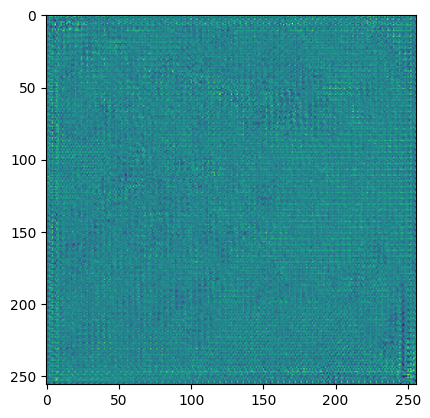

In [106]:
plt.imshow(pred[1, 0, :, :].detach().numpy())

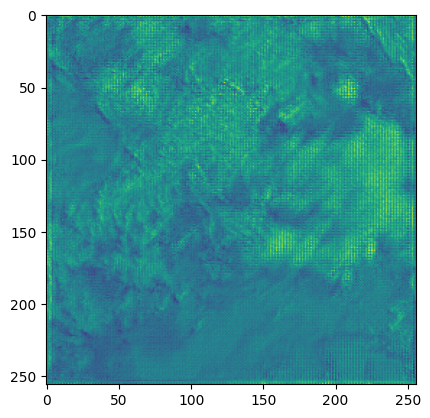

In [107]:
plt.imshow(pred_unt[1, 0, :, :].detach().numpy())

In [120]:
bb_main_model = model.to(config.DEVICE)

In [121]:
_expr_name = "ResNetUNet_AshRGB"
tb_path = "tb_obj2/backbone_model"
logger = pl.loggers.TensorBoardLogger(tb_path, name=_expr_name)

In [122]:
# Criterion
criterion = TverskyLoss()
# Gradient clipping
torch.nn.utils.clip_grad_norm_(bb_main_model.parameters(), max_norm=1.0)
# Scheduler
scheduler_name = 'ReduceLROnPlateau'
scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}

In [123]:
# Training Model
lgt_bbmodel = SegmentLightning(
            model=bb_main_model,
            criterion=criterion,
            learning_rate=0.0001,
            scheduler_name=scheduler_name,
            scheduler_params = scheduler_params,
            train_dataset=train_dataset,
            val_dataset=valid_dataset,
            batch_size=8
        )
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=f'./model_checkpoints/obj2/' +_expr_name,
            monitor="val_loss",
            save_last=True,
            save_top_k=3
        )

In [ ]:
torch.cuda.empty_cache()
trainer = pl.Trainer(
            max_epochs=30,
            logger=logger,
            precision=config.PRECISION,
            accelerator=config.ACCELERATOR,
            devices=[0],
            min_epochs=1,
            callbacks=[checkpoint_callback, early_stop_callback],
        )
trainer.fit(lgt_bbmodel)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_obj2/backbone_model/ResNetUNet_AshRGB
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type         | Params
--------------------------------------------------
0 | model            | ResNetUnet   | 59.8 M
1 | criterion        | TverskyLoss  | 0     
2 | iou              | JaccardIndex | 0     
3 | dice_coefficient | Dice         | 0     
--------------------------------------------------
59.8 M    Trainable params
0         Non-trainable params
59.8 M    Total params
119.577   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### DeepLabV3 

In [19]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from torchmetrics import JaccardIndex, Dice

class DeepLabV3Lightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-4, scheduler_params=None, train_dataset=None, val_dataset=None, batch_size=8, num_workers=2):
        super(DeepLabV3Lightning, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
        self.model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))  # Change the final layer to output 1 channel
        self.criterion = TverskyLoss()
        self.learning_rate = learning_rate
        self.scheduler_params = scheduler_params
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.iou = JaccardIndex(num_classes=2)
        self.dice_coefficient = Dice()

    def forward(self, x):
        return self.model(x)['out']

    def training_step(self, batch, batch_idx):
        data, targets = batch
        outputs = self.forward(data)
        loss = self.criterion(outputs, targets)
        dice_coefficient = self.dice_coefficient(outputs, targets.to(torch.uint8))
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_dice', dice_coefficient, on_epoch=True, prog_bar=True)
        return {'loss': loss, 'dice': dice_coefficient}

    def validation_step(self, batch, batch_idx):
        data, targets = batch
        outputs = self.forward(data)
        loss = self.criterion(outputs, targets)
        iou = self.iou(outputs, targets.to(torch.uint8))
        dice_coefficient = self.dice_coefficient(outputs, targets.to(torch.uint8))
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_iou', iou, on_epoch=True, prog_bar=True)
        self.log('val_dice', dice_coefficient, on_epoch=True, prog_bar=True)
        return {'loss': loss, 'iou': iou, 'dice': dice_coefficient}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **self.scheduler_params)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [27]:
dlabv3_model = DeepLabV3Lightning(learning_rate=1e-4, scheduler_params={'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}, 
                           train_dataset=train_dataset, val_dataset=valid_dataset)

In [29]:
logger = pl.loggers.TensorBoardLogger('tb_obj2/backbone_model', name='DeepLabV3_AshRGB_TvrkLoss')
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=3, save_last=True)
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [30]:
trainer = pl.Trainer(max_epochs=30,
                    logger=logger,
                    precision=config.PRECISION,
                    accelerator=config.ACCELERATOR,
                    devices=[0],
                    min_epochs=1,
                    callbacks=[checkpoint_callback, early_stop_callback],)
trainer.fit(dlabv3_model)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_obj2/backbone_model/DeepLabV3_AshRGB_TvrkLoss
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type              | Params
-------------------------------------------------------
0 | model            | DeepLabV3         | 42.0 M
1 | criterion        | BCEWithLogitsLoss | 0     
2 | iou              | JaccardIndex      | 0     
3 | dice_coefficient | Dice              | 0     
-------------------------------------------------------
42.0 M    Trainable params
0         Non-trainable params
42.0 M    Total params
83.998    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### PSPNet(Pyramid Scene Parsing Network) Model 

In [57]:
import torch.nn.functional as F
class PSPNet(nn.Module):
    def __init__(self, num_classes=1, backbone='resnet50', pretrained=True):
        super(PSPNet, self).__init__()
        self.backbone = getattr(torchvision.models, backbone)(pretrained=pretrained)
        self.layer0 = nn.Sequential(self.backbone.conv1, self.backbone.bn1, self.backbone.relu, self.backbone.maxpool)
        self.layer1 = self.backbone.layer1
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4

        self.ppm = PyramidPoolingModule(2048, 512)
        self.final = nn.Conv2d(4096, num_classes, kernel_size=1)

    def forward(self, x):
        h, w = x.size(2), x.size(3)  # get the height and width of the input image
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.ppm(x)
        x = self.final(x)
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)  # upsample to original image size
        return x

class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PyramidPoolingModule, self).__init__()
        self.pool1 = nn.AdaptiveAvgPool2d(1)
        self.pool2 = nn.AdaptiveAvgPool2d(2)
        self.pool3 = nn.AdaptiveAvgPool2d(3)
        self.pool6 = nn.AdaptiveAvgPool2d(6)

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv6 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.relu = nn.ReLU(inplace=True)
        self._init_weight()

    def _init_weight(self):
        for m in self.children():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        _, _, h, w = x.size()
        pool1 = F.interpolate(self.relu(self.conv1(self.pool1(x))), (h, w), mode='bilinear', align_corners=True)
        pool2 = F.interpolate(self.relu(self.conv2(self.pool2(x))), (h, w), mode='bilinear', align_corners=True)
        pool3 = F.interpolate(self.relu(self.conv3(self.pool3(x))), (h, w), mode='bilinear', align_corners=True)
        pool6 = F.interpolate(self.relu(self.conv6(self.pool6(x))), (h, w), mode='bilinear', align_corners=True)
        return torch.cat([x, pool1, pool2, pool3, pool6], dim=1)

In [58]:
class PSPNetLightning(pl.LightningModule):
    def __init__(self, model, criterion, learning_rate, scheduler_params, train_dataset, val_dataset, batch_size, num_workers):
        super(PSPNetLightning, self).__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.scheduler_params = scheduler_params
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.iou = JaccardIndex(num_classes=2)
        self.dice_coefficient = Dice()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        data, targets = batch
        img_grid = torchvision.utils.make_grid(data) # sample data test in TB
        self.logger.experiment.add_image("contrails_images", img_grid[0:3], self.global_step)
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        dice_coefficient = self.dice_coefficient(outputs, targets.to(torch.uint8))
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_dice', dice_coefficient, on_epoch=True, prog_bar=True)
        return {'loss': loss, 'dice': dice_coefficient}

    def validation_step(self, batch, batch_idx):
        data, targets = batch
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        iou = self.iou(outputs, targets.to(torch.uint8))
        dice_coefficient = self.dice_coefficient(outputs, targets.to(torch.uint8))
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_iou', iou, on_epoch=True, prog_bar=True)
        self.log('val_dice', dice_coefficient, on_epoch=True, prog_bar=True)
        return {'loss': loss, 'iou': iou, 'dice': dice_coefficient}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **self.scheduler_params)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [59]:
pspnet_model = PSPNet(num_classes=1, backbone='resnet50', pretrained=True)
psp_lightning_model = PSPNetLightning(
        model=pspnet_model,
        criterion=nn.BCEWithLogitsLoss(),
        learning_rate=1e-4,
        scheduler_params={'factor': 0.1, 'patience': 3, 'min_lr': 1e-6},
        train_dataset=train_dataset,
        val_dataset=valid_dataset,
        batch_size=8,
        num_workers=4
    )

In [60]:
logger = pl.loggers.TensorBoardLogger('tb_obj2/backbone_model', name='PSPNet_AshRGB_BCELoss')
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss', 
                                                   save_top_k=3, save_last=True)
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [61]:
trainer = pl.Trainer(max_epochs=30,
                    logger=logger,
                    precision=config.PRECISION,
                    accelerator=config.ACCELERATOR,
                    devices=[0],
                    min_epochs=1,
                    callbacks=[checkpoint_callback, early_stop_callback],)
trainer.fit(psp_lightning_model)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type              | Params
-------------------------------------------------------
0 | model            | PSPNet            | 29.8 M
1 | criterion        | BCEWithLogitsLoss | 0     
2 | iou              | JaccardIndex      | 0     
3 | dice_coefficient | Dice              | 0     
-------------------------------------------------------
29.8 M    Trainable params
0         Non-trainable params
29.8 M    Total params
59.511    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]